In [1]:
#coding=utf8

In [2]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

In [3]:
import torch
from torch import nn, optim

In [4]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from collections import Iterable

In [5]:
torch.manual_seed(1)
HSIC_epochs = 1
POST_epochs = 1

In [6]:
def kernel_matrix(x : torch.Tensor, sigma):
    dim = len(x.size())
    x1  = torch.unsqueeze(x, 0)
    x2  = torch.unsqueeze(x, 1)
    axis= tuple(range(2, dim+1))
    if dim > 1:
        return torch.exp( -0.5 * torch.sum(torch.pow(x1-x2, 2), axis=axis) / sigma**2)
    else:
        return torch.exp( -0.5 * torch.pow(x1-x2, 2) / sigma**2)

In [7]:
def HSIC(Kx, Ky, m):
    xy = torch.matmul(Kx, Ky)
    h  = torch.trace(xy) / m**2 + torch.mean(Kx)*torch.mean(Ky) - 2 * torch.mean(xy)/m
    return h*(m/(m-1))**2 

In [8]:
class HSICBottleneck:
    def __init__(self, model, batch_size, lambda_0, sigma, multi_sigma=None,lr=0.01):   
        # self.model      = model
        self.model      = Extractor(model)
        self.batch_size = batch_size
        self.lambda_0   = lambda_0
        self.sigma      = sigma
        self.extractor  = 'hsic'
        # self.trainable  = []
        self.lr         = lr
        self.multi_sigma = multi_sigma
        assert isinstance(self.multi_sigma, Iterable) if  multi_sigma is not None else True
        
        self.opt = optim.RMSprop(self.model.parameters(), lr)
        # self.opt = optim.SGD(self.trainable, lr)
        self.remember = []
        
    def step(self, input_data, labels):
        Kx  = kernel_matrix(input_data, self.sigma)
        Ky = kernel_matrix(labels, self.sigma)
        
        total_loss = 0.
        
        y_pred, hidden_zs = self.model(input_data)
        
        for name, layer in self.model.named_children():
            
            if self.extractor in name:
                hidden_z = hidden_zs[name]
                Kz = kernel_matrix(hidden_z, self.sigma)
                loss = HSIC(Kz, Kx, self.batch_size) - self.lambda_0*HSIC(Kz,Ky, self.batch_size)
                total_loss += loss
        
        self.opt.zero_grad()
        total_loss.backward()
        self.opt.step()
        
        self.remember.append(total_loss.item())
                
        return total_loss.item()

    def multi_sigma_step(self, input_data, labels):
        # TODO
        if self.multi_sigma is None:
            return self.step(input_data, labels)
        Kx = []
        Ky = []
        
        for sigma in self.multi_sigma:
            Kx.append(kernel_matrix(input_data, self.sigma))
            Ky.append(kernel_matrix(labels, self.sigma))
        
        total_loss = 0.
        
        y_pred, hidden_zs = self.model(input_data)
        
        for name, layer in self.model.named_children():
            #TODO
            if self.extractor in name:
                hidden_z = hidden_zs[name]
                Kz = []
                for sigma in self.multi_sigma:
                    Kz.append(kernel_matrix(hidden_z, self.sigma))
                loss = 0.
                for i in range(len(self.multi_sigma)):
                    loss += HSIC(Kz[i], Kx[i], self.batch_size) - self.lambda_0*HSIC(Kz[i], Ky[i], self.batch_size)
                total_loss += loss
        
        self.opt.zero_grad()
        total_loss.backward()
        self.opt.step()
        
        self.remember.append(total_loss.item())
                
        return total_loss.item()

In [9]:
class Test_model(nn.Module):
    def __init__(self):
        super(Test_model, self).__init__()
        self.hsic1 = nn.Linear(10, 20)
        self.f1 = nn.ReLU()
        self.f3 = nn.Dropout(p=0.2)
        self.hsic2 = nn.Linear(20, 32)
        self.hsic3 = nn.Linear(32, 16)
        self.output_layer  = nn.Linear(16, 1)
        self.f2 = nn.Sigmoid()
        
    def forward(self, data):
        x = self.f1(self.hsic1(data))
        x = self.f1(self.hsic2(x))
        x = self.f3(x)
        x = self.f1(self.hsic3(x))
        x = self.f2(self.output_layer(x))
        return x

In [10]:
class Extractor(nn.Module):
    def __init__(self, model : nn.Module):
        super(Extractor, self).__init__()
        self.extractor_pre = 'hsic'
        self.all_layers = []
        for name, layer in model.named_children():
            setattr(self, name, layer)
            self.all_layers.append(name)
        # set all_layers to tuple, fix its order
        self.all_layers = tuple(self.all_layers)
    
    def forward(self, data):
        x = data
        hidden = {}
        for name in self.all_layers:
            name : str
            layer = getattr(self,name)
            x = layer(x)
            if name.startswith(self.extractor_pre):
                hidden[name] = x
        return x, hidden

In [11]:
X = np.random.standard_normal((256*400, 10))
y = np.uint8(np.sum(X ** 2, axis=-1) > 25.).reshape((-1,1))
print(f"POS: {np.sum(y)}.   NEG: {len(y) - np.sum(y)}")

POS: 502.   NEG: 101898


In [16]:
X = torch.Tensor(X)
y = torch.Tensor(y)

In [17]:
num_train = 256 * 360
X_train = X[:num_train, :]
y_train = y[:num_train]
X_test  = X[num_train:, :]
y_test  = y[num_train:]

In [18]:
model = Test_model()
model.train()
# HSIC training
batch_size = 256
hsic = HSICBottleneck(model, batch_size=256, lambda_0=100., sigma=10.)

In [19]:
type(y_train[0].item())

float

In [20]:
for epoch in range(HSIC_epochs):
    print("===============================")
    print("EPOCH %d" % epoch)
    index = np.arange(len(X_train))
    np.random.shuffle(index)
    X_train = X_train[index]
    y_train = y_train[index]
    for batch in range(0, int(num_train/batch_size)):    
        data_x = X_train[batch*batch_size : (batch+1)*batch_size]
        label  = y_train[batch*batch_size : (batch+1)*batch_size]
        loss = hsic.step(data_x, label)
        if batch % 50 == 0:
            sys.stdout.write("%6.6f =>" % loss)
            sys.stdout.flush()
    sys.stdout.write('\n')

EPOCH 0
0.000906 =>0.000977 =>0.001301 =>0.001035 =>0.001053 =>-0.000136 =>-0.003609 =>0.004621 =>


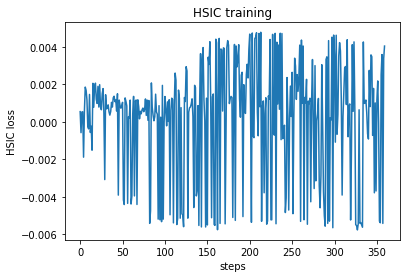

In [19]:
plt.plot(range(len(hsic.remember)), hsic.remember)
plt.title("HSIC training")
plt.xlabel("steps")
plt.ylabel("HSIC loss")
plt.show()

In [51]:
# Post training
criterion = nn.BCELoss()
post = PostTrained(model, criterion=criterion)

In [52]:
for epoch in range(POST_epochs):
    print("===============================")
    print("POST EPOCH %d" % epoch)
    index = np.arange(len(X_train))
    np.random.shuffle(index)
    X_train = X_train[index]
    y_train = y_train[index]
    for batch in range(0, int(num_train/batch_size)):    
        data_x = X_train[batch*batch_size : (batch+1)*batch_size]
        label  = y_train[batch*batch_size : (batch+1)*batch_size]
        loss = post.step(data_x, label)
        if batch % 50 == 0:
            sys.stdout.write("%6.6f =>" % loss)
            sys.stdout.flush()
    sys.stdout.write('\n')

POST EPOCH 0
0.586148 =>0.026702 =>0.005841 =>0.045832 =>0.006077 =>0.004637 =>0.068912 =>0.046899 =>


In [ ]:
class Test_model(nn.Module):
    def __init__(self):
        super(Test_model, self).__init__()
        self.hsic1 = nn.Linear(10, 20)
        self.f1 = nn.ReLU()
        self.f3 = nn.Dropout(p=0.2)
        self.hsic2 = nn.Linear(20, 32)
        self.hsic3 = nn.Linear(32, 16)
        self.output_layer  = nn.Linear(16, 1)
        self.f2 = nn.Sigmoid()
        
    def forward(self, data):
        x = self.f1(self.hsic1(data))
        x = self.f1(self.hsic2(x))
        x = self.f3(x)
        x = self.f1(self.hsic3(x))
        x = self.f2(self.output_layer(x))
        return x

In [ ]:
class Extractor(nn.Module):
    def __init__(self, model : nn.Module):
        super(Extractor, self).__init__()
        self.extractor_pre = 'hsic'
        self.all_layers = []
        for name, layer in model.named_children():
            setattr(self, name, layer)
            self.all_layers.append(name)
        # set all_layers to tuple, fix its order
        self.all_layers = tuple(self.all_layers)
    
    
    def forward(self, data):
        x = data
        hidden = {}
        for name in self.all_layers:
            name : str
            layer = getattr(self,name)
            x = layer(x)
            if name.startswith(self.extractor_pre):
                hidden[name] = x
        return x, hidden

In [50]:
class PostTrained:
    def __init__(self, model : nn.Module, criterion,lr=0.1):
        parameters = []
        model.train()
        for name, layer in model.named_children():
            if name == "output_layer":
                for params in layer.parameters():
                    parameters.append(params)
            else:
                for params in layer.parameters():
                    params.requires_grad = False
        self.opt   = optim.RMSprop(parameters, lr)
        self.model = model
        self.lr    = lr
        self.criterion = criterion

    def step(self, input_data, labels):
        output_data = self.model(input_data)
        loss = self.criterion(output_data, labels)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss.item()

In [26]:
def test_kernel(sigma=0.5):
    x   = np.random.rand(100,10)
    x   = torch.from_numpy(x)
    mat = kernel_matrix(x, sigma)
    print(mat.size(), "supposed to be (100,100)")
    x   = np.random.rand(100,128,128)
    x   = torch.from_numpy(x)
    mat = kernel_matrix(x, sigma)
    print(mat.size(), "supposed to be (100,100)")